### Comparison of crime rates before and after the outbreak of COVID-19 in Vancouver, Canada


Crime rates are one of the key indicators of community safety, and major social events such as political change and public health emergency of international concern can have the potential to impact and destabilize crime rates.


Based on the most recent major health emergency event: COVID-19, we will use the time point of this outbreak, i.e. Early 2020, as the dividing line, to compare the crime rates in Vancouver **three years ago (2017-2019)** and **three years later (2020-2022)**.


In this project, the main question which we want to figure out is:
#### TBD


Our dataset contains crime information in Vancouver (all regions covered according to `VPD Open Data`) from 2017-2022, and including information such as:
- `TYPE`: The type of crime activities.
- `YEAR`, `MONTH`, `DAY`, `HOUR`, `MINUTE`: The time when the reported crime activity occured. (Based on the finding of the police investigation.)
- `HUNDRED_BLOCK`: Generalized location of the reported crime activity.
- `NEIGHBOURHOOD`: The name of the neighbourhood where the location of the reported crime activity was belonged to.
- `X`, `Y`: Coordinate Values. 


For more information, please take a look at the website: https://vpd.ca/

First, we need to load the necessary libraries:

In [162]:
library(tidyverse)
library(GGally)
library(tidymodels)
library(broom)
library(repr)
library(infer)
library(ggplot2)
library(tidyr)

## 1. Loading the dataset

The first thing we do is to take a glance at the dataset to see what does it look like.

In [163]:
crime <- read.csv("crime_data/merged_csv_files.csv")
head(crime)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,8,29,21,30,19XX TURNER ST,Grandview-Woodland,495232.4238,5458486.6121
2,Theft from Vehicle,2017,12,25,21,0,19XX UPLAND DR,Victoria-Fraserview,495089.4532,5451695.1098
3,Theft from Vehicle,2017,3,24,22,30,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
4,Theft from Vehicle,2017,10,23,9,22,19XX VENABLES ST,Grandview-Woodland,495231.0367,5458207.3987
5,Theft from Vehicle,2017,7,3,21,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018
6,Theft from Vehicle,2017,11,10,16,0,19XX W 11TH AVE,Kitsilano,489210.9151,5456573.0018


In case we might do comparison between different communities, we would filter out NA data in `NEIGHBOURHOOD` column, and the weird string type in `YEAR` column.

In [164]:
crime <- crime %>%
        filter(!is.na(NEIGHBOURHOOD)) %>%
        filter(!(YEAR == "YEAR")) %>%
        subset(YEAR >= 2017 & YEAR <= 2022)

Firstly, we can simply do a comparison of general crime rates in different years from 2017-2022 to see the general tendency.

YEAR,CRIME
<chr>,<int>
2017,43214
2018,44266
2019,48144
2020,37506
2021,32189
2022,34189


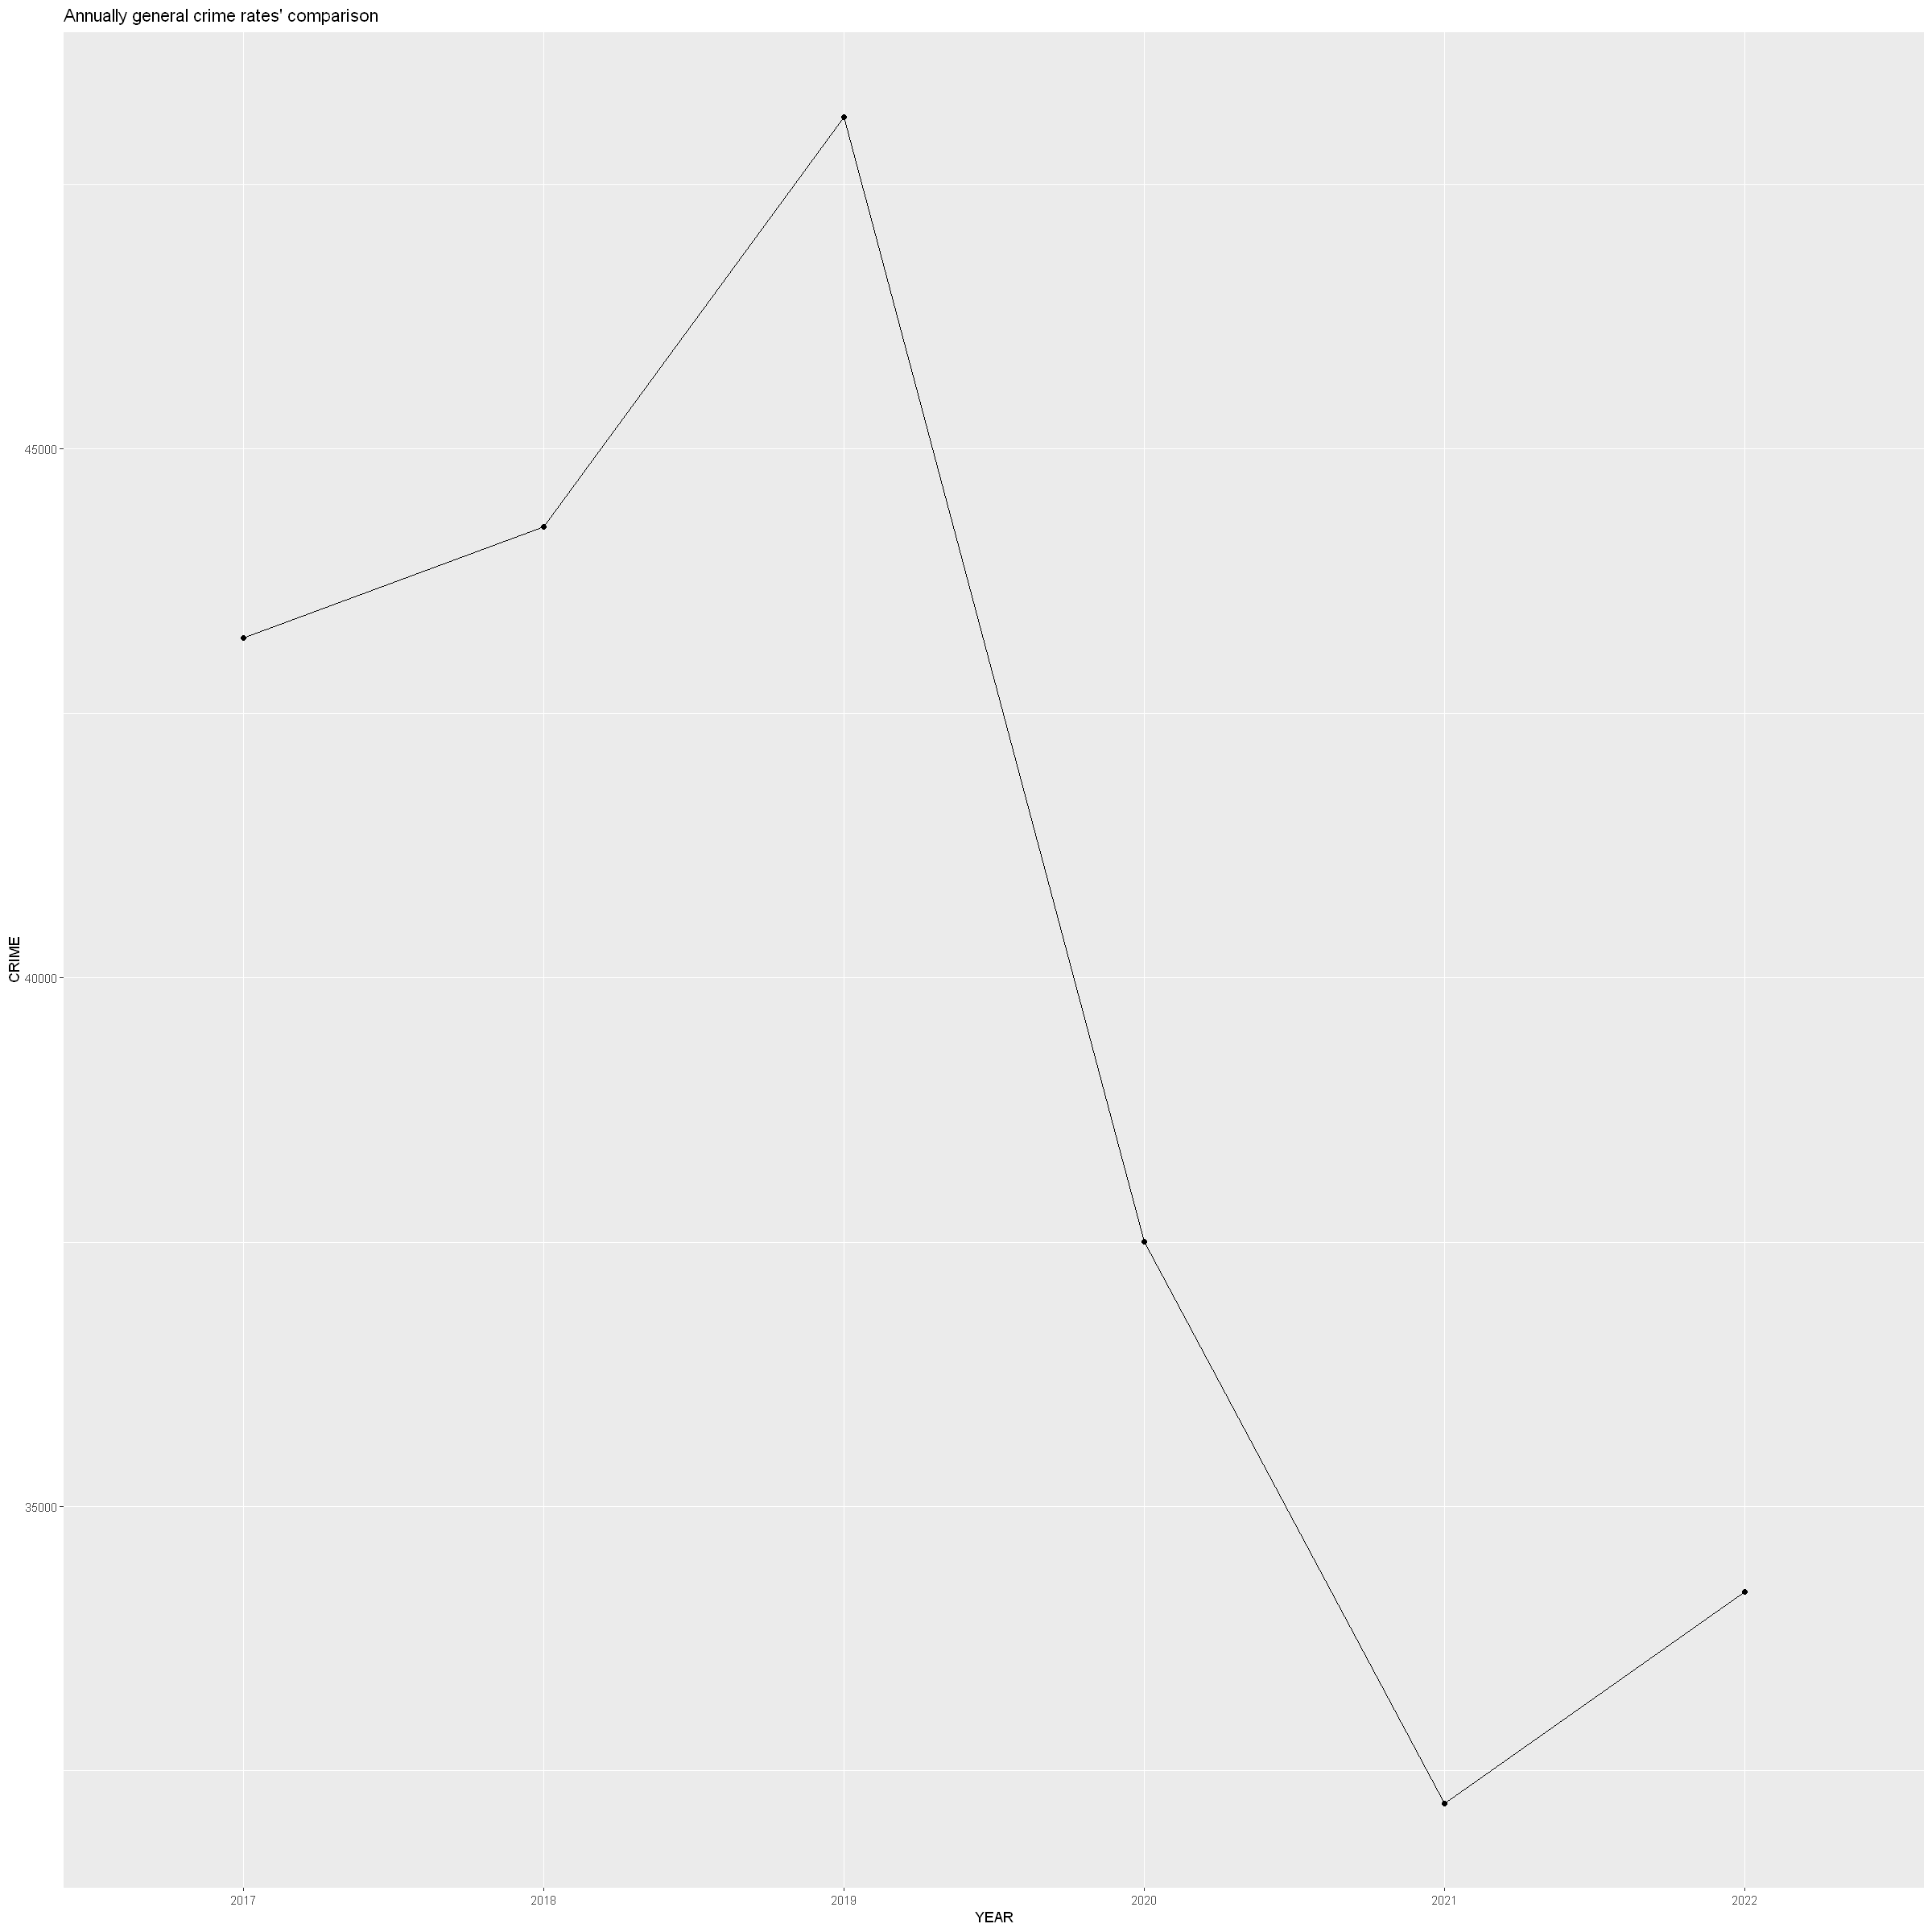

In [165]:
annual_general_crime <- crime %>%
               group_by(YEAR) %>%
               summarise(CRIME = n())

annual_general_crime

annual_general_crime_plot <- annual_general_crime %>%
               ggplot(aes(x = YEAR, y = CRIME, group = 1)) +
               geom_line() +
               geom_point() +
               ggtitle("Annually general crime rates' comparison")

annual_general_crime_plot

From the visualized plot above, we can figure out that since the outbreak of COVID-19 occurred, the general crime ratio has a precipitous fall.
We would assume that the pandemic does restrict people's activities and interactions.

Continuously, according to the background of the pandemic, we would do analysis on specific `TYPE` of crime, and at specific locations, `NEIGHBOURHOOD`.

According to the columns we will target to from above, we would first filter out the useless columns to simplify the chart.

In [166]:
crime <- crime %>%
     select(TYPE, YEAR, NEIGHBOURHOOD)

head(crime)

,TYPE,YEAR,NEIGHBOURHOOD
,<chr>,<chr>,<chr>
1,Theft from Vehicle,2017,Grandview-Woodland
2,Theft from Vehicle,2017,Victoria-Fraserview
3,Theft from Vehicle,2017,Grandview-Woodland
4,Theft from Vehicle,2017,Grandview-Woodland
5,Theft from Vehicle,2017,Kitsilano
6,Theft from Vehicle,2017,Kitsilano


Now we have filter the chart, we would visualize it by grouping by `TYPE` and `YEAR` to observe which type of crime happened more frequently.

For the column `YEAR`, because we treat the outbreak of COVID-19 as the time point, we would combine the data of 2017-2019, and 2020-2022 together respectively.

In [167]:
# Refactor `YEAR` column into `COVID_OUTBREAK` column
out_break <- crime %>%
    mutate(COVID_OUTBREAK = case_when(
        YEAR <= 2019 ~ "Before_COVID",
        YEAR >= 2020 ~ "During_COVID"
    ))

# Group by `TYPE` and `COVID_OUTBREAK` for analysis
criming <- out_break %>%
    group_by(TYPE, COVID_OUTBREAK) %>%
    count() %>%
    spread(key = TYPE, value = n, fill = 0)

transposed_crime <- t(criming)

transposed_crime


COVID_OUTBREAK,Before_COVID,During_COVID
Break and Enter Commercial,6702,6851
Break and Enter Residential/Other,7114,4839
Homicide,44,49
Mischief,16920,17122
Offence Against a Person,9716,11371
Other Theft,35382,27964
Theft from Vehicle,44956,25187
Theft of Bicycle,6590,4964
Theft of Vehicle,4019,2604
Vehicle Collision or Pedestrian Struck (with Fatality),41,46


Now we get the general data of the amount of each type of crime before covid and after covid, and we can visualize them to do a comparison and observe which `TYPE` has an abnormal change.

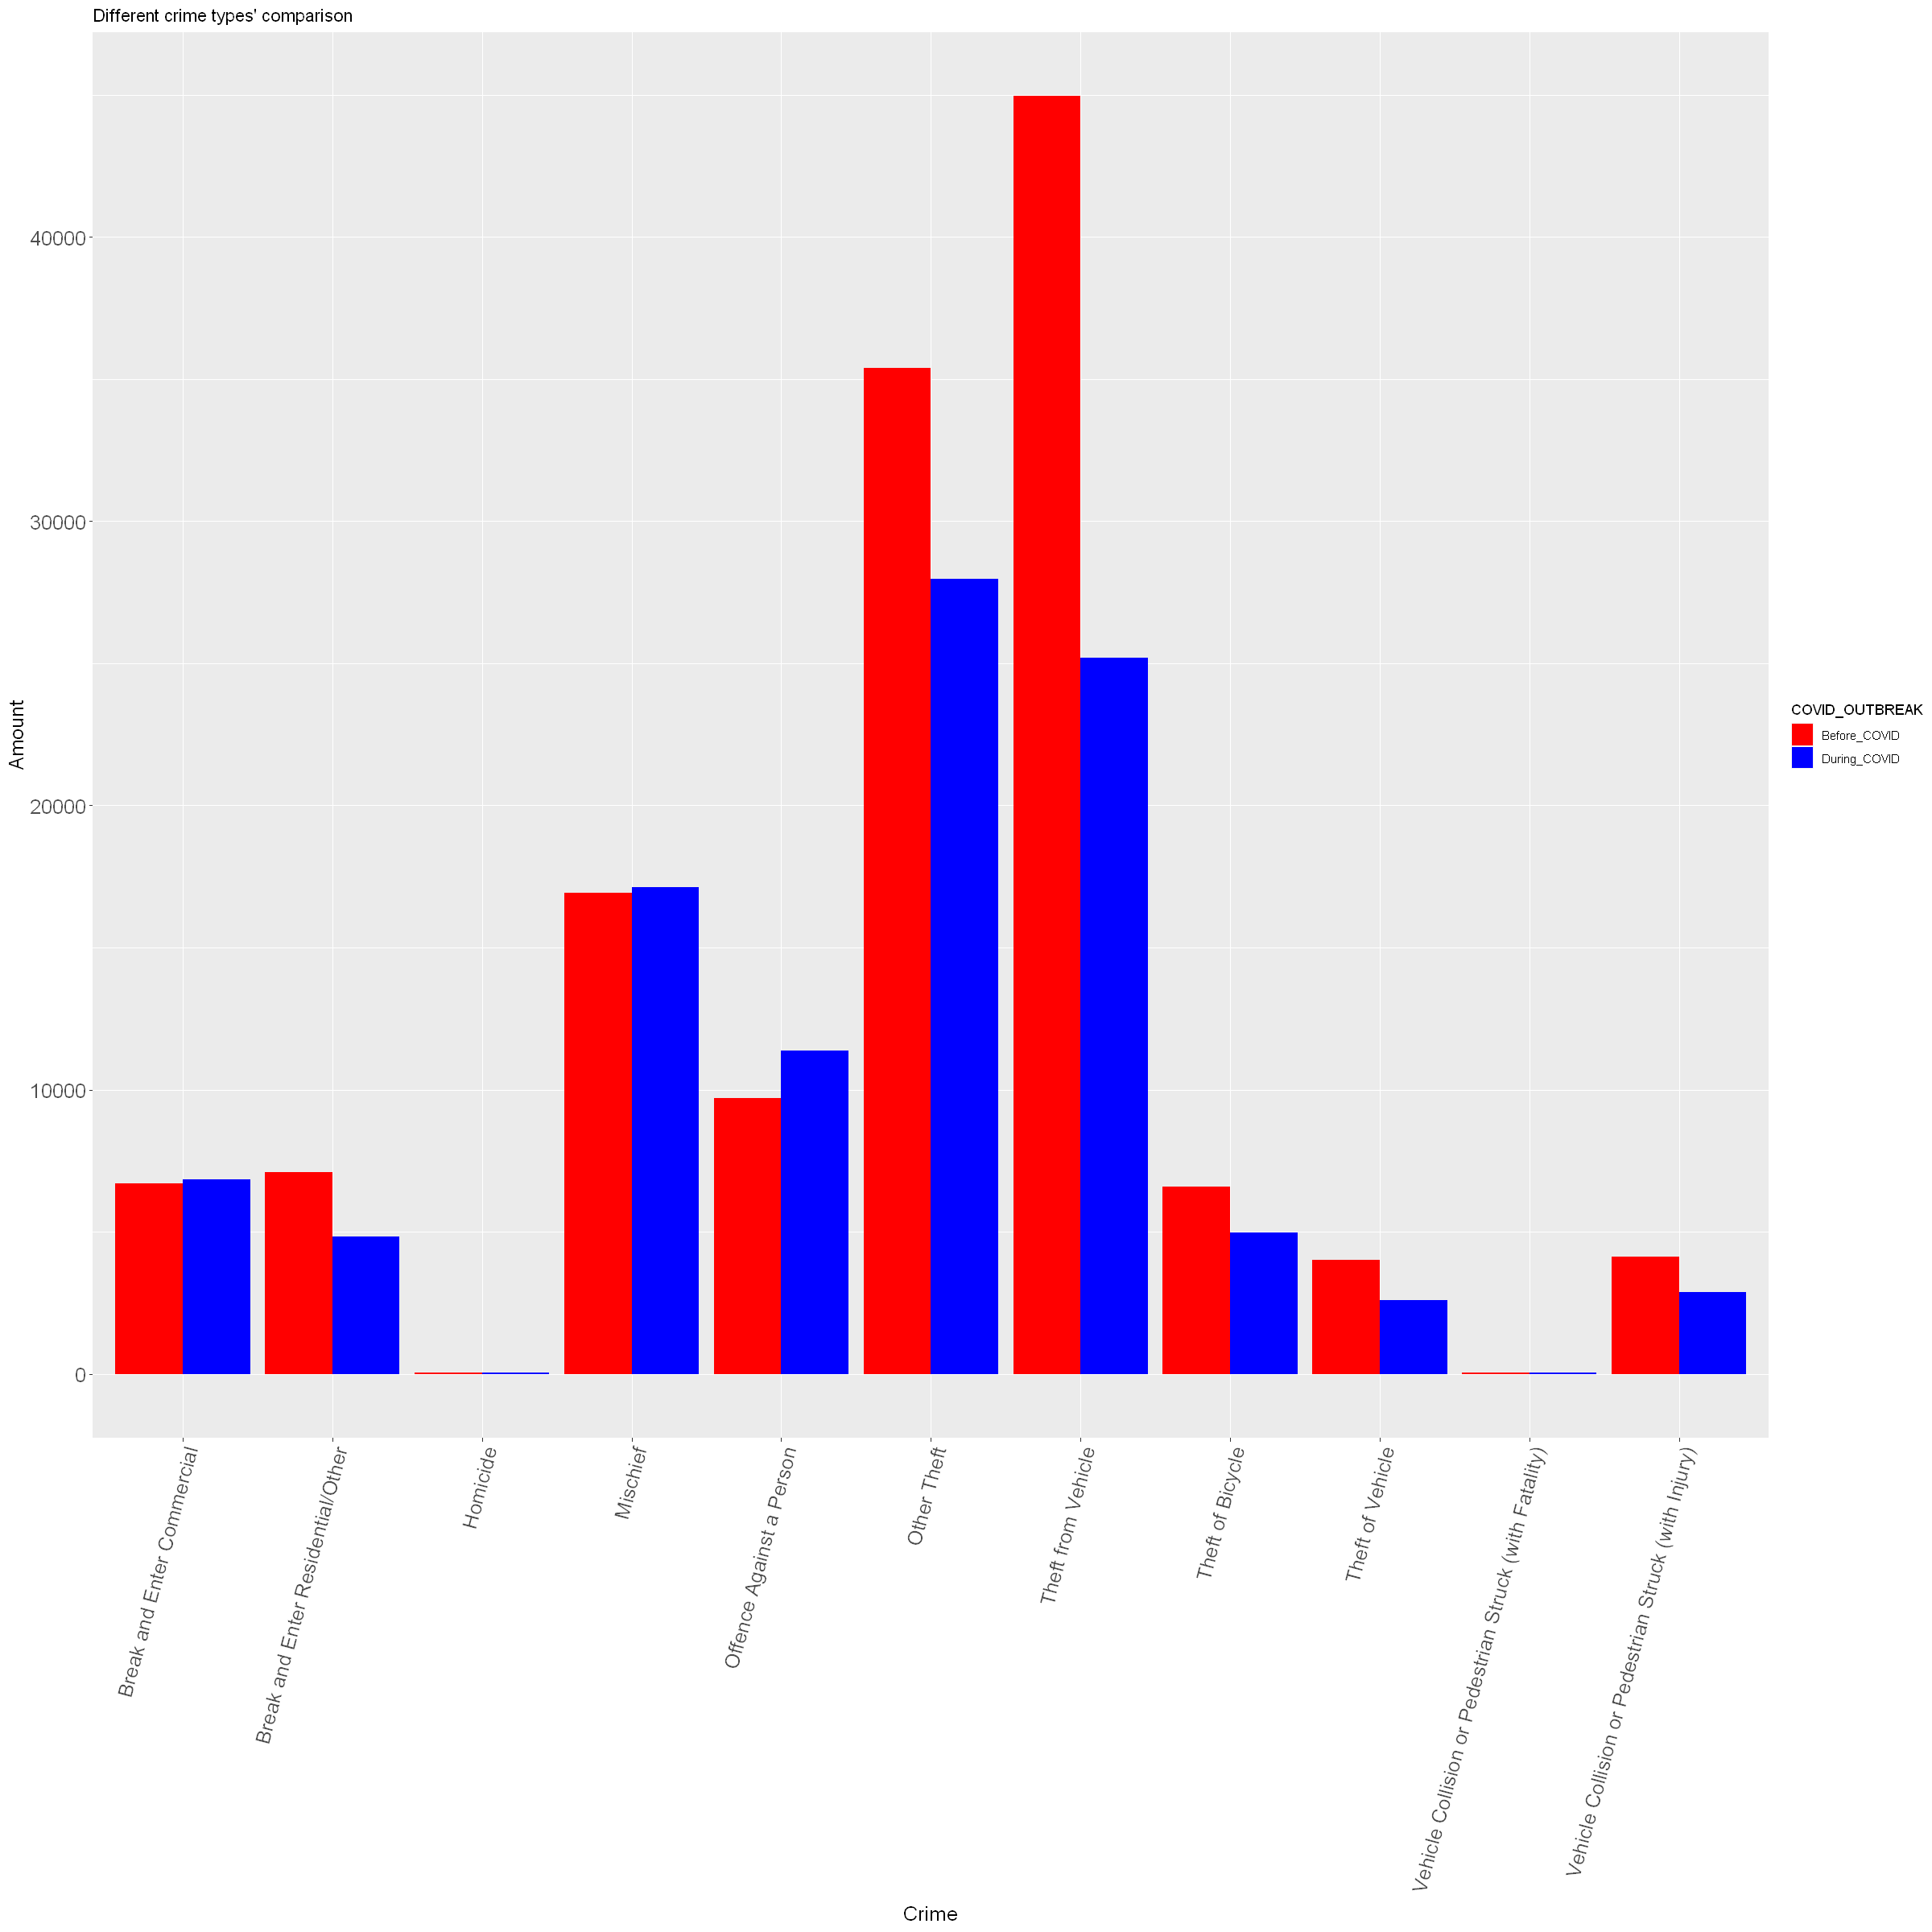

In [168]:
set.seed(123)

frame_crime <- as.data.frame(criming)

frame_crime_long <- pivot_longer(frame_crime, 
                                 -COVID_OUTBREAK,
                                 names_to = "Crime",
                                 values_to = "Value")

diff_crime_plot <- frame_crime_long %>%
    ggplot(aes(x = Crime, y = Value, fill = COVID_OUTBREAK)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("red", "blue")) +
    labs(x = "Crime", y = "Amount", fill = "COVID_OUTBREAK") +
    ggtitle("Different crime types' comparison") +
    theme(axis.text.x = element_text(angle = 75, vjust = 1, hjust = 1),
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 15))

options(repr.plot.width = 20, repr.plot.height = 20)

diff_crime_plot

As we can see from the bar plot above, the ratio of different crime types are generally decreasing, while some of them were increasing instead.

Among these types which have abnormal change, we would like to see the one with the biggest decresing first: `Offence Against a Person`.

In [177]:
crime_for_offence <- crime %>%
    filter(TYPE == "Offence Against a Person") %>%
    select(YEAR)

head(crime_for_offence)

,YEAR
,<chr>
1,2017
2,2017
3,2017
4,2017
5,2017
6,2017


According to what we have learned, we will use **bootstrapping distribution** to see whether the frequency of this type's crime got higher around the outbreak of COVID-19.

replicate,mean_year
<int>,<dbl>
1,2019.50
2,2019.70
3,2019.36
4,2019.84
5,2019.62
6,2019.36


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


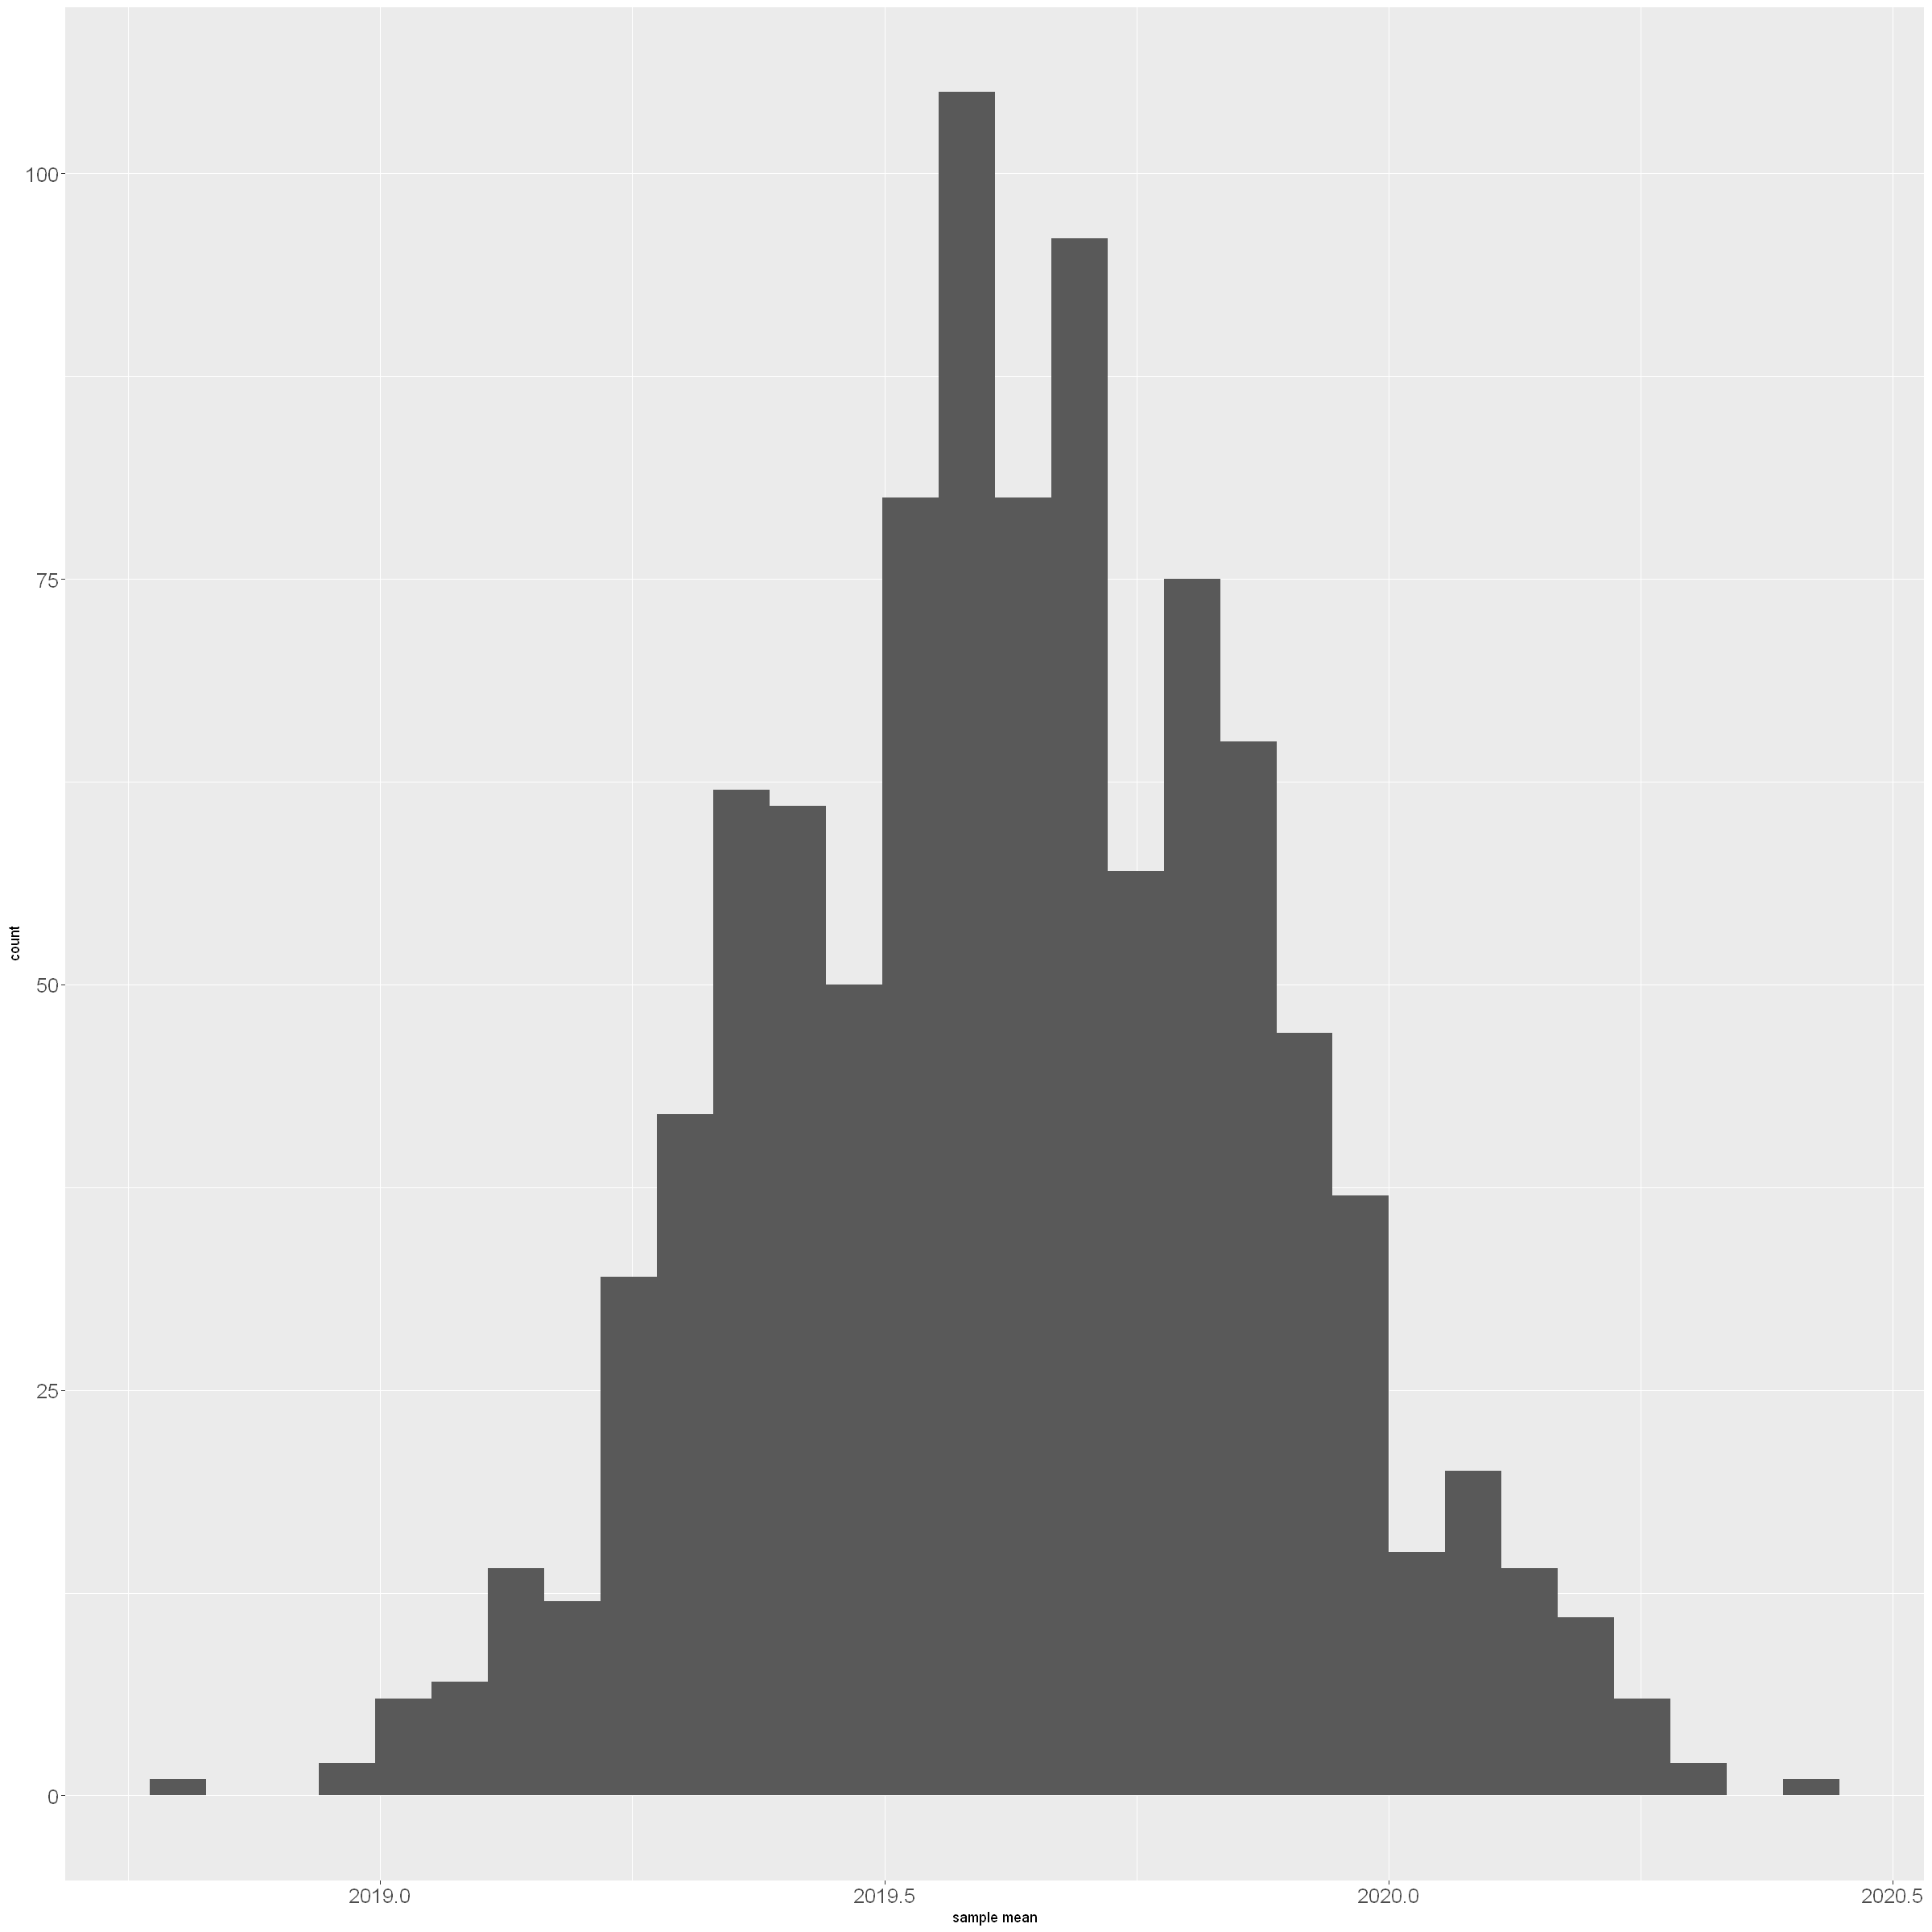

In [195]:
# make the data in the YEAR column numerical
crime_for_offence$YEAR <- as.numeric(crime_for_offence$YEAR)

# Distribution
crime_data_filtered <- crime_for_offence %>%
    rep_sample_n(size = 50, replace = TRUE, reps = 1000) %>%
    group_by(replicate) %>%
    summarise(mean_year = mean(YEAR))
head(crime_data_filtered)

# Visualization
crime_data_filtered_vis <- ggplot(crime_data_filtered, aes(x = mean_year)) +
    geom_histogram() +
    labs(x = "sample mean") +
    theme(axis.text = element_text(size = 15))

crime_data_filtered_vis